# PROTOTYPE 1: static FEA and modal analysis for 1D geometries - bar and beam elements

The initial development of the library began with this Jupyter Notebook. The idea was to facilitate interactive experimentation and visualization. 
This preliminary notebook-driven  development was ideal for:
- Rapid prototyping of element formulations (e.g., Euler-Bernoulli beam elements)
- Testing stiffness matrix assembly procedures
- Visualizing mode shapes and validating results
- Debugging in a modular and incremental way

After validating the methodology in the notebook environment, the code has been refactored into reusable and well-defined functions.

Once core functions were tested independently, they were structured into a Python package **fem_toolbox**

### Imports

In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
# using sympy only for printing
import sympy as sy

### Element stiffness matrices for rod and beam

In [2]:
def k_rod(E, A, L):
    """2-node rod element stiffness matrix"""
    k = (E*A/L) * np.array([[1, -1], 
                            [-1, 1]])
    return k

def k_beam(E, I, L):
    """2-node beam element stiffness matrix (Euler Bernoulli beam)"""
    k = (E*I/L**3) * np.array([[12, 6*L, -12, 6*L],
                             [6*L, 4*L**2, -6*L, 2*L**2],
                             [-12, -6*L, 12, -6*L],
                             [6*L, 2*L**2, -6*L, 4*L**2]]) 
    return k

### Element mass matrices for rod and beam (consistent not lumped!)

In [3]:
def m_rod(rho, A, L):
    """Consistent mass matrix for bar element"""
    m = rho * A * L / 6 * np.array([
        [2, 1],
        [1, 2]
    ])
    return m


def m_beam(rho, A, L):
    """Consistent mass matrix for 2-node Euler-Bernoulli beam element"""
    m = rho * A * L / 420 * np.array([
        [156, 22*L, 54, -13*L],
        [22*L, 4*L**2, 13*L, -3*L**2],
        [54, 13*L, 156, -22*L],
        [-13*L, -3*L**2, -22*L, 4*L**2]
    ])
    return m



### Geometry, material and discretization definition - user or file input

In [4]:
length = 1000   

# Discretization 
num_elements = 5

# Material 
E = 210000   # N/mm^2 steel

# Geometry
#A = np.pi/4*(10)**2    # mm^2 
#I = np.pi/4 * (10)**4   # mm^4, formula for circular section

A = 3.24e2
I = 3.99e4
# density
rho = 7.85e-6      # kg/mm^3

properites = [E, A, I]

### Nodal coordinates matrix - element connectivity matrix

In [5]:
# Generating node coordinates
num_nodes = num_elements + 1
node_coords = np.linspace(0, length, num_nodes)

# connectivity matrix (each row: [start_node, end_node])
connectivity = np.array([[i, i+1] for i in range(num_elements)])

# verifying
display(node_coords)
display(connectivity)

mesh = [node_coords, connectivity]


array([   0.,  200.,  400.,  600.,  800., 1000.])

array([[0, 1],
       [1, 2],
       [2, 3],
       [3, 4],
       [4, 5]])

### Assembling global stiffness matrix

In [6]:
# since 1D, no coordinate transformation is needed

def assembleK_rod():
    # global matrix K initialization
    dof_per_node = 1
    total_dof = num_nodes * dof_per_node
    K_rod = np.zeros((total_dof, total_dof)) 

    # global matrix filling 
    for element in connectivity:
        n1, n2 = element
        # extract coordinates of the nodes of the element
        x1, x2 = node_coords[n1], node_coords[n2]
        l_elem = x2 - x1

        # evaluating stiffness matrix k for the single element
        k_elem = k_rod(E, A, l_elem)

        # defining the dof mapping 
        dof_map_rod = [n1 * dof_per_node, n2 * dof_per_node]
        dof_per_element = dof_per_node * 2

        # assembly of global stiffness matrix
        for i in range(dof_per_element):
            for j in range(dof_per_element):
                K_rod[dof_map_rod[i], dof_map_rod[j]] += k_elem[i, j]
        
    return K_rod



def assembleK_beam():
    # global matrix K initialization
    dof_per_node = 2    # vertical displacement v and rotation θ
    total_dof = num_nodes * dof_per_node
    K_beam = np.zeros((total_dof, total_dof)) 

    # global matrix filling 
    for element in connectivity:
        n1, n2 = element
        # extract coordinates of the nodes of the element
        x1, x2 = node_coords[n1], node_coords[n2]
        l_elem = x2 - x1

        # evaluating stiffness matrix k for the single element
        k_elem = k_beam(E, I, l_elem)

        # defining the dof mapping 
        dof_map_beam = [
        n1 * dof_per_node,     # v_i
        n1 * dof_per_node + 1, # θ_i
        n2 * dof_per_node,     # v_j
        n2 * dof_per_node + 1  # θ_j
    ]
        dof_per_element = dof_per_node * 2  # since every element has 2 nodes

        # assembly
        for i in range(dof_per_element):
            for j in range(dof_per_element):
                K_beam[dof_map_beam[i], dof_map_beam[j]] += k_elem[i, j]
        
    return K_beam

### Assemble global mass matrix

Note that the routines for assembling mass matrix and stiffness matrix are identical. What changes is:
- dofs per node (1 for rod, 2 for beam), and consequently the matrix dimension
- the function call for the element matrix (k, m, either for rod or beam)
- the dof mapping is different

So should be very straightforward to implement a routine accounting for all this cases


In [7]:
# no coordinate transformation needed since 1D

def assembleM_rod():
    # global matrix K initialization
    dof_per_node = 1
    total_dof = num_nodes * dof_per_node
    M_rod = np.zeros((total_dof, total_dof)) 

    # global matrix filling 
    for element in connectivity:
        n1, n2 = element
        # extract coordinates of the nodes of the element
        x1, x2 = node_coords[n1], node_coords[n2]
        l_elem = x2 - x1

        # evaluating stiffness matrix k for the single element
        m_elem = m_rod(rho, A, l_elem)

        # defining the dof mapping 
        dof_map_rod = [n1 * dof_per_node, n2 * dof_per_node]
        dof_per_element = dof_per_node * 2

        # assembly of global stiffness matrix
        for i in range(dof_per_element):
            for j in range(dof_per_element):
                M_rod[dof_map_rod[i], dof_map_rod[j]] += m_elem[i, j]
        
    return M_rod


def assembleM_beam():
    dof_per_node = 2
    total_dof = num_nodes * dof_per_node
    M_beam = np.zeros((total_dof, total_dof))

    # global matrix filling
    for element in connectivity:
        n1, n2 = element
        x1, x2 = node_coords[n1], node_coords[n2]
        l_elem = x2 - x1

        # evaluating mass matrix for the single element
        m_elem = m_beam(rho, A, l_elem)

        dof_map_beam = [
        n1 * dof_per_node,     # v_i
        n1 * dof_per_node + 1, # θ_i
        n2 * dof_per_node,     # v_j
        n2 * dof_per_node + 1  # θ_j
        ]

        dof_per_element = dof_per_node * 2

        for i in range(dof_per_element):
            for j in range(dof_per_element):
                M_beam[dof_map_beam[i], dof_map_beam[j]] += m_elem[i, j]

    return M_beam

### Check 

In [8]:
K_rod = assembleK_rod()
K_beam = assembleK_beam()

M_rod = assembleM_rod()
M_beam = assembleM_beam()

# comment if you don't have sympy installed, used print instead
display(sy.Matrix(K_rod))
display(sy.Matrix(K_beam))
display(sy.Matrix(M_rod), sy.Matrix(M_beam))

Matrix([
[ 340200.0, -340200.0,         0,         0,         0,         0],
[-340200.0,  680400.0, -340200.0,         0,         0,         0],
[        0, -340200.0,  680400.0, -340200.0,         0,         0],
[        0,         0, -340200.0,  680400.0, -340200.0,         0],
[        0,         0,         0, -340200.0,  680400.0, -340200.0],
[        0,         0,         0,         0, -340200.0,  340200.0]])

Matrix([
[  12568.5,   1256850.0,   -12568.5,   1256850.0,          0,           0,          0,           0,          0,           0,          0,           0],
[1256850.0, 167580000.0, -1256850.0,  83790000.0,          0,           0,          0,           0,          0,           0,          0,           0],
[ -12568.5,  -1256850.0,    25137.0,           0,   -12568.5,   1256850.0,          0,           0,          0,           0,          0,           0],
[1256850.0,  83790000.0,          0, 335160000.0, -1256850.0,  83790000.0,          0,           0,          0,           0,          0,           0],
[        0,           0,   -12568.5,  -1256850.0,    25137.0,           0,   -12568.5,   1256850.0,          0,           0,          0,           0],
[        0,           0,  1256850.0,  83790000.0,          0, 335160000.0, -1256850.0,  83790000.0,          0,           0,          0,           0],
[        0,           0,          0,           0,   -12568.5,  -1256850.0,    25137.0

Matrix([
[0.16956, 0.08478,       0,       0,       0,       0],
[0.08478, 0.33912, 0.08478,       0,       0,       0],
[      0, 0.08478, 0.33912, 0.08478,       0,       0],
[      0,       0, 0.08478, 0.33912, 0.08478,       0],
[      0,       0,       0, 0.08478, 0.33912, 0.08478],
[      0,       0,       0,       0, 0.08478, 0.16956]])

Matrix([
[ 0.188938285714286,  5.32902857142857, 0.0654017142857143, -3.14897142857143,                  0,                 0,                  0,                 0,                  0,                 0,                  0,                 0],
[  5.32902857142857,  193.782857142857,   3.14897142857143, -145.337142857143,                  0,                 0,                  0,                 0,                  0,                 0,                  0,                 0],
[0.0654017142857143,  3.14897142857143,  0.377876571428571,                 0, 0.0654017142857143, -3.14897142857143,                  0,                 0,                  0,                 0,                  0,                 0],
[ -3.14897142857143, -145.337142857143,                  0,  387.565714285714,   3.14897142857143, -145.337142857143,                  0,                 0,                  0,                 0,                  0,                 0],
[                 0,                 0, 0.06540

## Developing and solving for the beam

Why it is needed to specialize? Because the beam has double the dofs of the rod, so different BC are needed, and also the force vector size is double
### Boundary conditions and force vector

How to write a general routine for 1d BC?
- the nodes are the same for rod, beam and 2d beam, so the nodes specification is the same
- a differentiation is needed on the prescribed dofs

THE SAME OBSERVATIONS HOLD FOR THE FORCE VECTOR




In [9]:
# BC: cantilever beam
boundary_nodes = np.array([0])
prescribed_dofs = boundary_nodes + [0, 1]    # BC on vertical displacement and rotation
prescribed_values = [0, 0]

# Force: downward force at last node
force_nodes = np.array([num_nodes])
prescribed_components = [0]     # only component v is prescribed
prescribed_force = np.array([-1000])

# initializing force vector
F_global_beam = np.zeros(K_beam.shape[0])
F_global_beam[(force_nodes * 2 - 2) + prescribed_components] = prescribed_force

display(sy.Matrix(F_global_beam))

Matrix([
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[-1000.0],
[      0]])

### Partition of the system equations

##### Why do we need this?

In the finite element method, the global system of equations is:


$K \cdot U = F$


where:
- $ K $ is the global stiffness matrix
- $ U $ is the global displacement (unknowns)
- $ F $ is the global force vector

When some degrees of freedom (DOFs) have prescribed displacements (e.g., fixed supports), we split the system into **free** and **prescribed** DOFs:

$$
\begin{bmatrix}
K_{ff} & K_{fp} \\
K_{pf} & K_{pp}
\end{bmatrix}
\begin{bmatrix}
U_f \\
U_p
\end{bmatrix}
=
\begin{bmatrix}
F_f \\
F_p
\end{bmatrix}
$$

Where:
- $ U_p $ are the **prescribed displacements** (known)
- $ U_f $ are the **free displacements** (unknown)
- $ K_{ff} $ is the submatrix for free-free DOFs
- $ K_{fp} $ is the coupling submatrix between free and prescribed DOFs
- $ F_f $ is the force vector corresponding to free DOFs

Since $ U_p $ is known (e.g., zero for fixed supports), we can reduce the system to:

$
K_{ff} \cdot U_f = F_f - K_{fp} \cdot U_p
$

This reduced system is then solved for \( U_f \), and the full solution vector \( U \) is reconstructed by combining \( U_f \) and \( U_p \).

In [10]:
# Determine free DOFs vector
total_dofs = K_beam.shape[0]
all_dofs = np.arange(total_dofs)
free_dofs = np.setdiff1d(all_dofs, prescribed_dofs)

# Split stiffness matrix and force vector
K_ff = K_beam[np.ix_(free_dofs, free_dofs)]     # submatrix relating only free DOFs
K_fp = K_beam[np.ix_(free_dofs, prescribed_dofs)]   # coupling submatrix between free and prescribed DOFs
F_f = F_global_beam[free_dofs]
U_p = np.array(prescribed_values)

# check
display(free_dofs, F_f, F_f.shape, U_p)

# adjusting force vector to account for the known values from the boundary conditions
F_eff = F_f - K_fp @ U_p


array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
       -1000.,     0.])

(10,)

array([0, 0])

### System solution: displacement

Units in mm, see above

In [11]:
# Solve the system
U_f = linalg.solve(K_ff, F_eff)

# Assemble the full solution vector
U = np.zeros(total_dofs)
U[free_dofs] = U_f
U[prescribed_dofs] = U_p

# ### Display final displacement vector
display(sy.Matrix(U))

Matrix([
[                  0],
[                  0],
[  -2.22779170147588],
[-0.0214822771213745],
[  -8.27465489119611],
[-0.0381907148824437],
[  -17.1858216970996],
[-0.0501253132832074],
[  -28.0065242471254],
[-0.0572860723236655],
[  -39.7819946692122],
[-0.0596729920038182]])

### System solution: reaction components

In [12]:
F_reconstructed = K_beam @ U
reactions = F_reconstructed[prescribed_dofs]

print("Reaction forces at constrained DOFs: ")
display(sy.Matrix(reactions))

Reaction forces at constrained DOFs: 


Matrix([
[999.999999999982],
[999999.999999983]])

### Stresses

For the beam, stress is evaluated after the computation of moment M. For the rod instead, the first derivative of the displacement yields the deformation, that's proportional to the stress 

In [13]:
bending_moments = []
stresses = []

for element in connectivity:
    n1, n2 = element
    # DOF mapping for this element
    dof_map = [
        n1 * 2, n1 * 2 + 1,
        n2 * 2, n2 * 2 + 1
    ]
    u_elem = U[dof_map]  # Extract local displacements
    x1, x2 = node_coords[n1], node_coords[n2]
    l_elem = x2 - x1
    
    # Local stiffness matrix
    k_elem = k_beam(E, I, l_elem)
    
    # Internal force vector
    f_int = k_elem @ u_elem  # Local internal forces

    # Moments are at DOF 1 and 3 (rotational DOFs)
    M1 = f_int[1]
    M2 = f_int[3]
    bending_moments.append((-M1, M2))

    # Stress = M * y / I (y = outer radius of circular section)
    R = 10 / 2  # radius of circular section
    sigma1 = -M1 * R / I
    sigma2 = M2 * R / I
    stresses.append((sigma1, sigma2))

# check
display(sy.Matrix(bending_moments), sy.Matrix(stresses))


# pretty output
for i, (mom, stress) in enumerate(zip(bending_moments, stresses)):
    print(f"Element {i}:")
    print(f"  Moments (N·mm):     M1 = {mom[0]:.2f}, M2 = {mom[1]:.2f}")
    print(f"  Max bending stress (N/mm²): σ1 = {stress[0]:.2f}, σ2 = {stress[1]:.2f}")

Matrix([
[-999999.999999983,    -799999.999999987],
[-799999.999999987,    -599999.999999997],
[-599999.999999996,    -399999.999999996],
[-399999.999999996,    -199999.999999989],
[-199999.999999994, -3.72529029846191e-9]])

Matrix([
[-125.313283208018,     -100.250626566414],
[-100.250626566414,     -75.1879699248117],
[-75.1879699248116,     -50.1253132832076],
[-50.1253132832076,     -25.0626566416026],
[-25.0626566416033, -4.66828358203247e-13]])

Element 0:
  Moments (N·mm):     M1 = -1000000.00, M2 = -800000.00
  Max bending stress (N/mm²): σ1 = -125.31, σ2 = -100.25
Element 1:
  Moments (N·mm):     M1 = -800000.00, M2 = -600000.00
  Max bending stress (N/mm²): σ1 = -100.25, σ2 = -75.19
Element 2:
  Moments (N·mm):     M1 = -600000.00, M2 = -400000.00
  Max bending stress (N/mm²): σ1 = -75.19, σ2 = -50.13
Element 3:
  Moments (N·mm):     M1 = -400000.00, M2 = -200000.00
  Max bending stress (N/mm²): σ1 = -50.13, σ2 = -25.06
Element 4:
  Moments (N·mm):     M1 = -200000.00, M2 = -0.00
  Max bending stress (N/mm²): σ1 = -25.06, σ2 = -0.00


### Solving the eigenvalue problem
#### General Eigenvalue Problem for Modal Analysis

In structural dynamics, the free vibration of a structure without damping and external forces leads to the following **eigenvalue problem**:

$$
K \cdot \mathbf{u} = \lambda M \cdot \mathbf{u}
$$

Where:
- \( K \) is the **global stiffness matrix**
- \( M \) is the **global mass matrix**
- \( \mathbf{u} \) is an **eigenvector**, representing the mode shape
- \( \lambda \) is an **eigenvalue**, related to the square of the angular natural frequency:
  
  $$
  \lambda = \omega^2
  $$

Once eigenvalues are computed, the **natural frequencies** \( f \) are obtained from:

$$
f = \frac{\omega}{2\pi} = \frac{\sqrt{\lambda}}{2\pi}
$$

Each pair $$ (f, \mathbf{u}) $$ represents a natural vibration mode:
- $ f $: frequency in Hz
- $ \mathbf{u} $: corresponding mode shape (relative displacement pattern)


In [14]:
from scipy.linalg import eigh  # for symmetric matrices

# Apply boundary conditions: reduce M and K
K_red = K_beam[np.ix_(free_dofs, free_dofs)]
M_red = M_beam[np.ix_(free_dofs, free_dofs)]

# Solve generalized eigenvalue problem (matrix is symmetric so use eigh)
eigenvals, eigenvecs = eigh(K_red, M_red)

# check
display(sy.Matrix(eigenvals), sy.Matrix(eigenvecs))


# Only keep positive eigenvalues 
positive_eigs = eigenvals[eigenvals > 1e-8]
omega = np.sqrt(positive_eigs)
frequencies = omega / (2 * np.pi)

# Show first few frequencies
print("First 5 natural frequencies (Hz):")
for i, f in enumerate(frequencies[:5]):
    print(f"  f{i+1} = {f:.2f} Hz")

Matrix([
[40.7277830531551],
[1601.09712971018],
[12630.5760857353],
[49291.3030523693],
[135786.382837616],
[374748.537324918],
[801559.594399888],
[1685792.03038529],
[3401986.54530176],
[ 7361887.3263831]])

Matrix([
[  0.0801009407818751,    0.377918450484357,    0.763584519483664,    -0.969801220466772,   -0.862831053623857,   0.486458517265579,  0.0633124910703739,  -0.355912421254204,   -0.509035357459561,   -0.106971348079701],
[0.000760637282704045,  0.00291741627498584,  0.00393882960447939, -0.000784236658828995,  0.00610239321213891, -0.0172726982888654, -0.0284099717515241, -0.0351885112068011,  -0.0314553834074796, -0.00545592846450311],
[    0.28829946254272,    0.857980033477132,    0.664890449035156,     0.402309835037487,    0.918050007025684,  -0.197969830840068,   0.696178580443952,   0.700807917339793,   -0.101621944593729,   -0.164195034298495],
[ 0.00128243677958316,   0.0012697412089212, -0.00512398071441083,   0.00897104784033712, -0.00171683362876129,  0.0202379774996406,  0.0166178912022609, -0.0200602017438844,   -0.055596873242067,  -0.0153856504948994],
[   0.578311804363397,    0.740010373470574,   -0.597893974505995,     0.425627002419115,   -0.916478111557424,

First 5 natural frequencies (Hz):
  f1 = 1.02 Hz
  f2 = 6.37 Hz
  f3 = 17.89 Hz
  f4 = 35.34 Hz
  f5 = 58.65 Hz


Note that we have 6 nodes (5 elements), so 12 dofs for the beam (v and theta for each node). Having imposed BC on the node number 0 (v = 0, theta = 0 for a cantilever beam), we have prescribed 2 dofs so we remain with 10 dofs. So when we reduce the stiffness and mass matrix we have a 10x10 system, and this yields 10 natural frequencies (and 10 eigenvalues)

### Plotting displacement


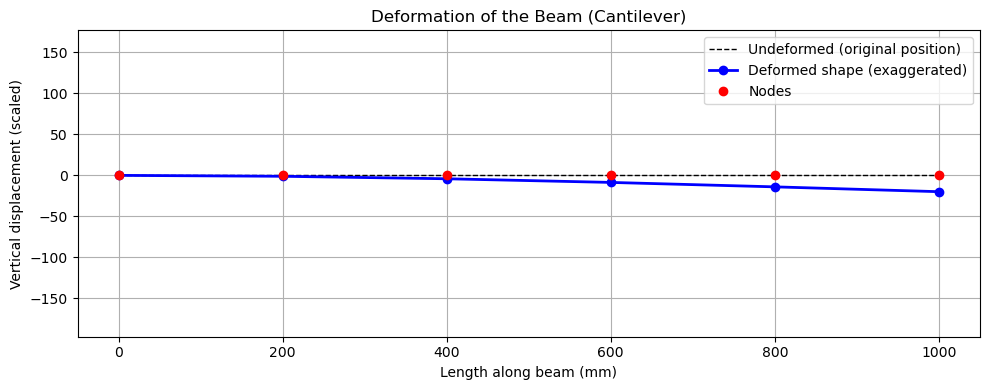

In [15]:
# Extracting only vertical displacement from U vector
v_disp = U[0::2]

x = node_coords
x_deformed = x
amplification = 0.5
y_deformed = v_disp * amplification

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(x, np.zeros_like(x), 'k--', label='Undeformed (original position)', linewidth=1)
plt.plot(x_deformed, y_deformed, 'b-o', label='Deformed shape (exaggerated)', linewidth=2, markersize=6)

# Plot nodes
plt.plot(x, np.zeros_like(x), 'ro', label='Nodes', markersize=6)

plt.xlabel("Length along beam (mm)")
plt.ylabel("Vertical displacement (scaled)")
plt.title("Deformation of the Beam (Cantilever)")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()


### Plotting internal actions 

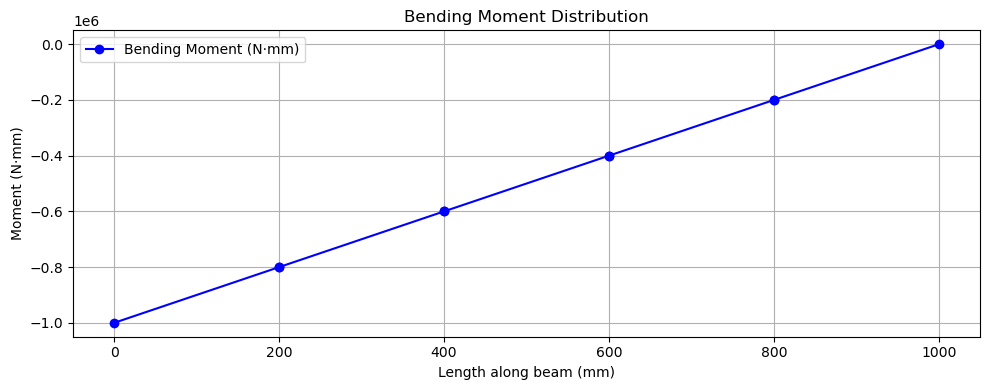

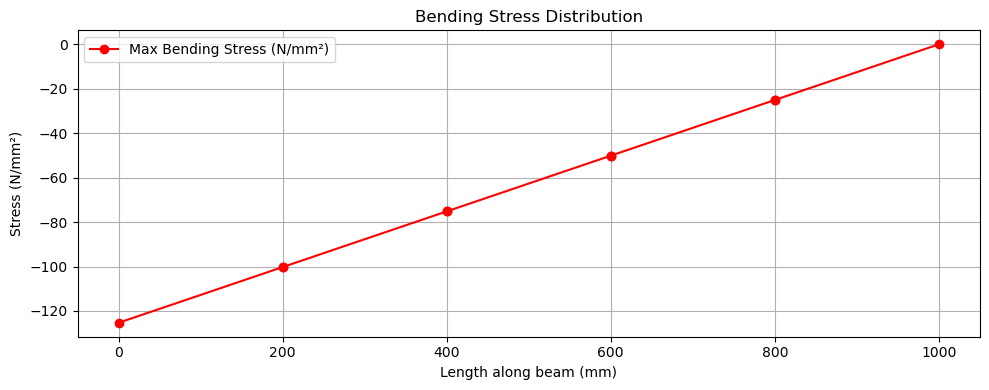

In [16]:
# Build x-coordinates for each element end
x_coords = []
moment_values = []
stress_values = []

for i, ((M1, M2), (s1, s2)) in enumerate(zip(bending_moments, stresses)):
    x1 = node_coords[i]
    x2 = node_coords[i+1]
    x_coords.extend([x1, x2])
    moment_values.extend([M1, M2])
    stress_values.extend([s1, s2])

# Plot Bending Moment Diagram
plt.figure(figsize=(10, 4))
plt.plot(x_coords, moment_values, 'b-o', label='Bending Moment (N·mm)')
plt.title("Bending Moment Distribution")
plt.xlabel("Length along beam (mm)")
plt.ylabel("Moment (N·mm)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Bending Stress Diagram
plt.figure(figsize=(10, 4))
plt.plot(x_coords, stress_values, 'r-o', label='Max Bending Stress (N/mm²)')
plt.title("Bending Stress Distribution")
plt.xlabel("Length along beam (mm)")
plt.ylabel("Stress (N/mm²)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Color plot for deformation and stress

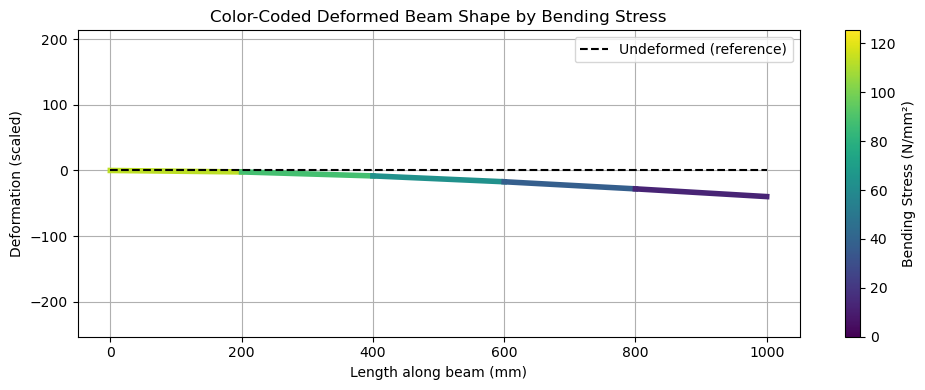

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# Get vertical displacements
v_disp = U[0::2]
amplification = 1
y_deformed = v_disp * amplification
x = node_coords

# --- Compute stress at each node (averaging adjacent elements) ---
node_stress = np.zeros(num_nodes)
count = np.zeros(num_nodes)

for i, (s1, s2) in enumerate(stresses):
    node_stress[i] += abs(s1)
    node_stress[i+1] += abs(s2)
    count[i] += 1
    count[i+1] += 1

node_stress /= count  # average

# --- Normalize stress for colormap ---
norm = colors.Normalize(vmin=np.min(node_stress), vmax=np.max(node_stress))
cmap = plt.colormaps['viridis']  # Updated way to get colormap

# --- Plot color-coded deformed shape ---
fig, ax = plt.subplots(figsize=(10, 4))

for i in range(num_nodes - 1):
    x_seg = [x[i], x[i+1]]
    y_seg = [y_deformed[i], y_deformed[i+1]]
    stress_avg = (node_stress[i] + node_stress[i+1]) / 2
    ax.plot(x_seg, y_seg, color=cmap(norm(stress_avg)), linewidth=4)

# Add colorbar (linked to the current axis explicitly)
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # Needed for colorbar
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Bending Stress (N/mm²)')

# Labels and base plot
ax.plot(x, np.zeros_like(x), 'k--', label='Undeformed (reference)')
ax.set_xlabel("Length along beam (mm)")
ax.set_ylabel("Deformation (scaled)")
ax.set_title("Color-Coded Deformed Beam Shape by Bending Stress")
ax.grid(True)
ax.axis('equal')
ax.legend()
plt.tight_layout()
plt.show()


### Animated plot for vibration modes

Trying from the beginning to build it as a stand-alone function, to copy-paste it in a .py for later use 

Matrix([
[                 0],
[0.0638709240707831],
[ 0.229884354690129],
[ 0.461134525826819],
[  0.72547766967158],
[               1.0]])

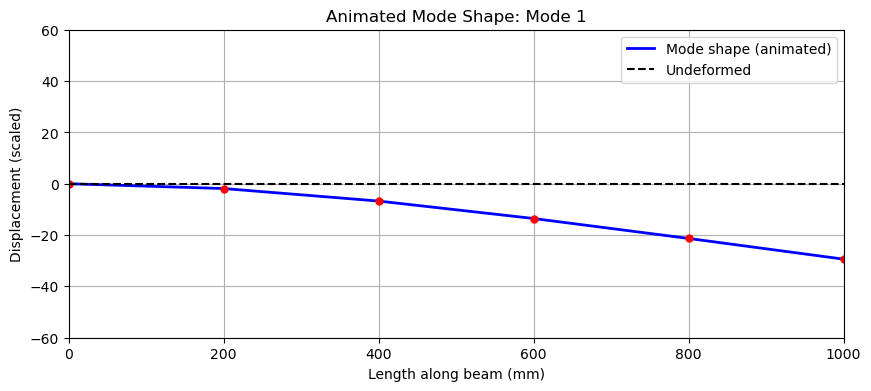

In [18]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# it's important to keep in mind that we have 12 dofs, of which 6 are vertical displacement. But since one vertical displacement has been prescribed (BC), it's mode shape will be zero. This has not been calculated from the eigenvalue analysis above, so it needs to be added

# Select the first mode shape
mode_index = 0

# Build the full mode vector for first natural frequency
full_mode = np.zeros(K_beam.shape[0])
full_mode[free_dofs] = eigenvecs[:, mode_index]

# Pick only the v components to build the mode shape
mode_shape = full_mode[0::2]

# Normalize mode shape for visualization
mode_shape /= np.max(np.abs(mode_shape))

# Amplify mode for visibility
amplification = 50
y_mode = mode_shape * amplification

# check
display(sy.Matrix(mode_shape))

# Create figure
fig, ax = plt.subplots(figsize=(10, 4))
line, = ax.plot([], [], 'b-', linewidth=2, label='Mode shape (animated)')
nodes, = ax.plot([], [], 'ro', markersize=5)

ax.plot(node_coords, np.zeros_like(node_coords), 'k--', label='Undeformed')
ax.set_xlim(0, length)
ax.set_ylim(-amplification*1.2, amplification*1.2)
ax.set_xlabel('Length along beam (mm)')
ax.set_ylabel('Displacement (scaled)')
ax.set_title(f'Animated Mode Shape: Mode {mode_index+1}')
ax.grid(True)
ax.legend()

# Animation function
def update(frame):
    factor = np.sin(frame / 10 * 2 * np.pi)
    y = y_mode * factor
    line.set_data(node_coords, y)
    nodes.set_data(node_coords, y)
    return line, nodes

ani = FuncAnimation(fig, update, frames=60, interval=50, blit=True)

# To display in notebook:
HTML(ani.to_jshtml())

In [19]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def animate_mode_shape(mode_index, eigenvecs, node_coords, free_dofs, K, amplification=50, save_as=None):
    """
    Animate the mode shape for a given mode index.

    Parameters:
    - mode_index: Index of the mode (0-based)
    - eigenvecs: Matrix of eigenvectors (columns = mode shapes, reduced system)
    - node_coords: Array of nodal coordinates
    - free_dofs: List of free DOF indices (used to reconstruct full mode)
    - K: Global stiffness matrix (used to determine total DOFs)
    - amplification: Visual amplification factor
    - save_as: If not None, filename to save (e.g., 'mode1.gif')
    
    Returns:
    - HTML animation if used in notebook
    """
    num_nodes = len(node_coords)

    # Reconstruct full mode vector including constrained DOFs
    full_mode = np.zeros(K.shape[0])
    full_mode[free_dofs] = eigenvecs[:, mode_index]
    
    mode_shape = full_mode[::2]  # vertical DOFs only

    # Normalize and amplify
    mode_shape /= np.max(np.abs(mode_shape))
    y_static = mode_shape * amplification

    # Plot setup
    fig, ax = plt.subplots(figsize=(10, 4))
    line, = ax.plot([], [], 'b-', linewidth=2, label='Mode shape (animated)')
    nodes, = ax.plot([], [], 'ro', markersize=5)

    ax.plot(node_coords, np.zeros_like(node_coords), 'k--', label='Undeformed')
    ax.set_xlim(0, node_coords[-1])
    ax.set_ylim(-amplification * 1.2, amplification * 1.2)
    ax.set_xlabel("Length along beam (mm)")
    ax.set_ylabel("Displacement (scaled)")
    ax.set_title(f"Animated Mode Shape {mode_index + 1}")
    ax.grid(True)

    # Animation update function
    def update(frame):
        factor = np.sin(2 * np.pi * frame / 30)
        y = y_static * factor
        line.set_data(node_coords, y)
        nodes.set_data(node_coords, y)
        return line, nodes

    ani = FuncAnimation(fig, update, frames=60, interval=50, blit=True)

    # Save or return animation
    if save_as:
        ani.save(save_as, writer='pillow')
        print(f"Animation saved to: {save_as}")
        plt.close(fig)
    else:
        plt.close(fig)
        return HTML(ani.to_jshtml())
    



In [20]:
animate_mode_shape(
    mode_index=1, 
    eigenvecs=eigenvecs, 
    node_coords=node_coords, 
    free_dofs=free_dofs, 
    K=K_beam, 
    amplification=50
)


In [21]:


animate_mode_shape(
    mode_index=3, 
    eigenvecs=eigenvecs, 
    node_coords=node_coords, 
    free_dofs=free_dofs, 
    K=K_beam, 
    amplification=50
)
